In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import xarray

In [3]:

model="GAM" 
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']


taxas =["Amphibians"]
dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Amphibians/EWEMBI/"
available_file = os.listdir(dir_species)
available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:10]

In [4]:

model="GAM" 
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']


taxas =["Amphibians"]
dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Amphibians/EWEMBI/"
available_file = os.listdir(dir_species)
available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:10]

#newvalue

def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model_name: {} for model_name in model_names}
    sum_bin_dict = {model_name: {} for model_name in model_names}

    for model_name in model_names:
        for species_name in species_names:
            if is_historical:
                ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
            else:
                ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
            newvalue = ds["newvalue"]
            sum_bin = ds["sum_bin"]

            newvalue_dict[model_name][species_name] = newvalue
            sum_bin_dict[model_name][species_name] = sum_bin

    projections_dict = {}

    for species_name in species_names:
        value_list = []
        for model_name in model_names:
            value_bin = newvalue_dict[model_name][species_name]
            value_list.append(value_bin)
        value_bin_concat = xr.concat(value_list, dim="model")
        mean_value_bin = value_bin_concat.mean(dim="model")
        projections_dict[species_name] = mean_value_bin

    value_bin_list = list(projections_dict.values())
    mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

    return mean_value_bin


In [6]:
mean_hist

<xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [7]:
mean_future

<xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [8]:
difference

<xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

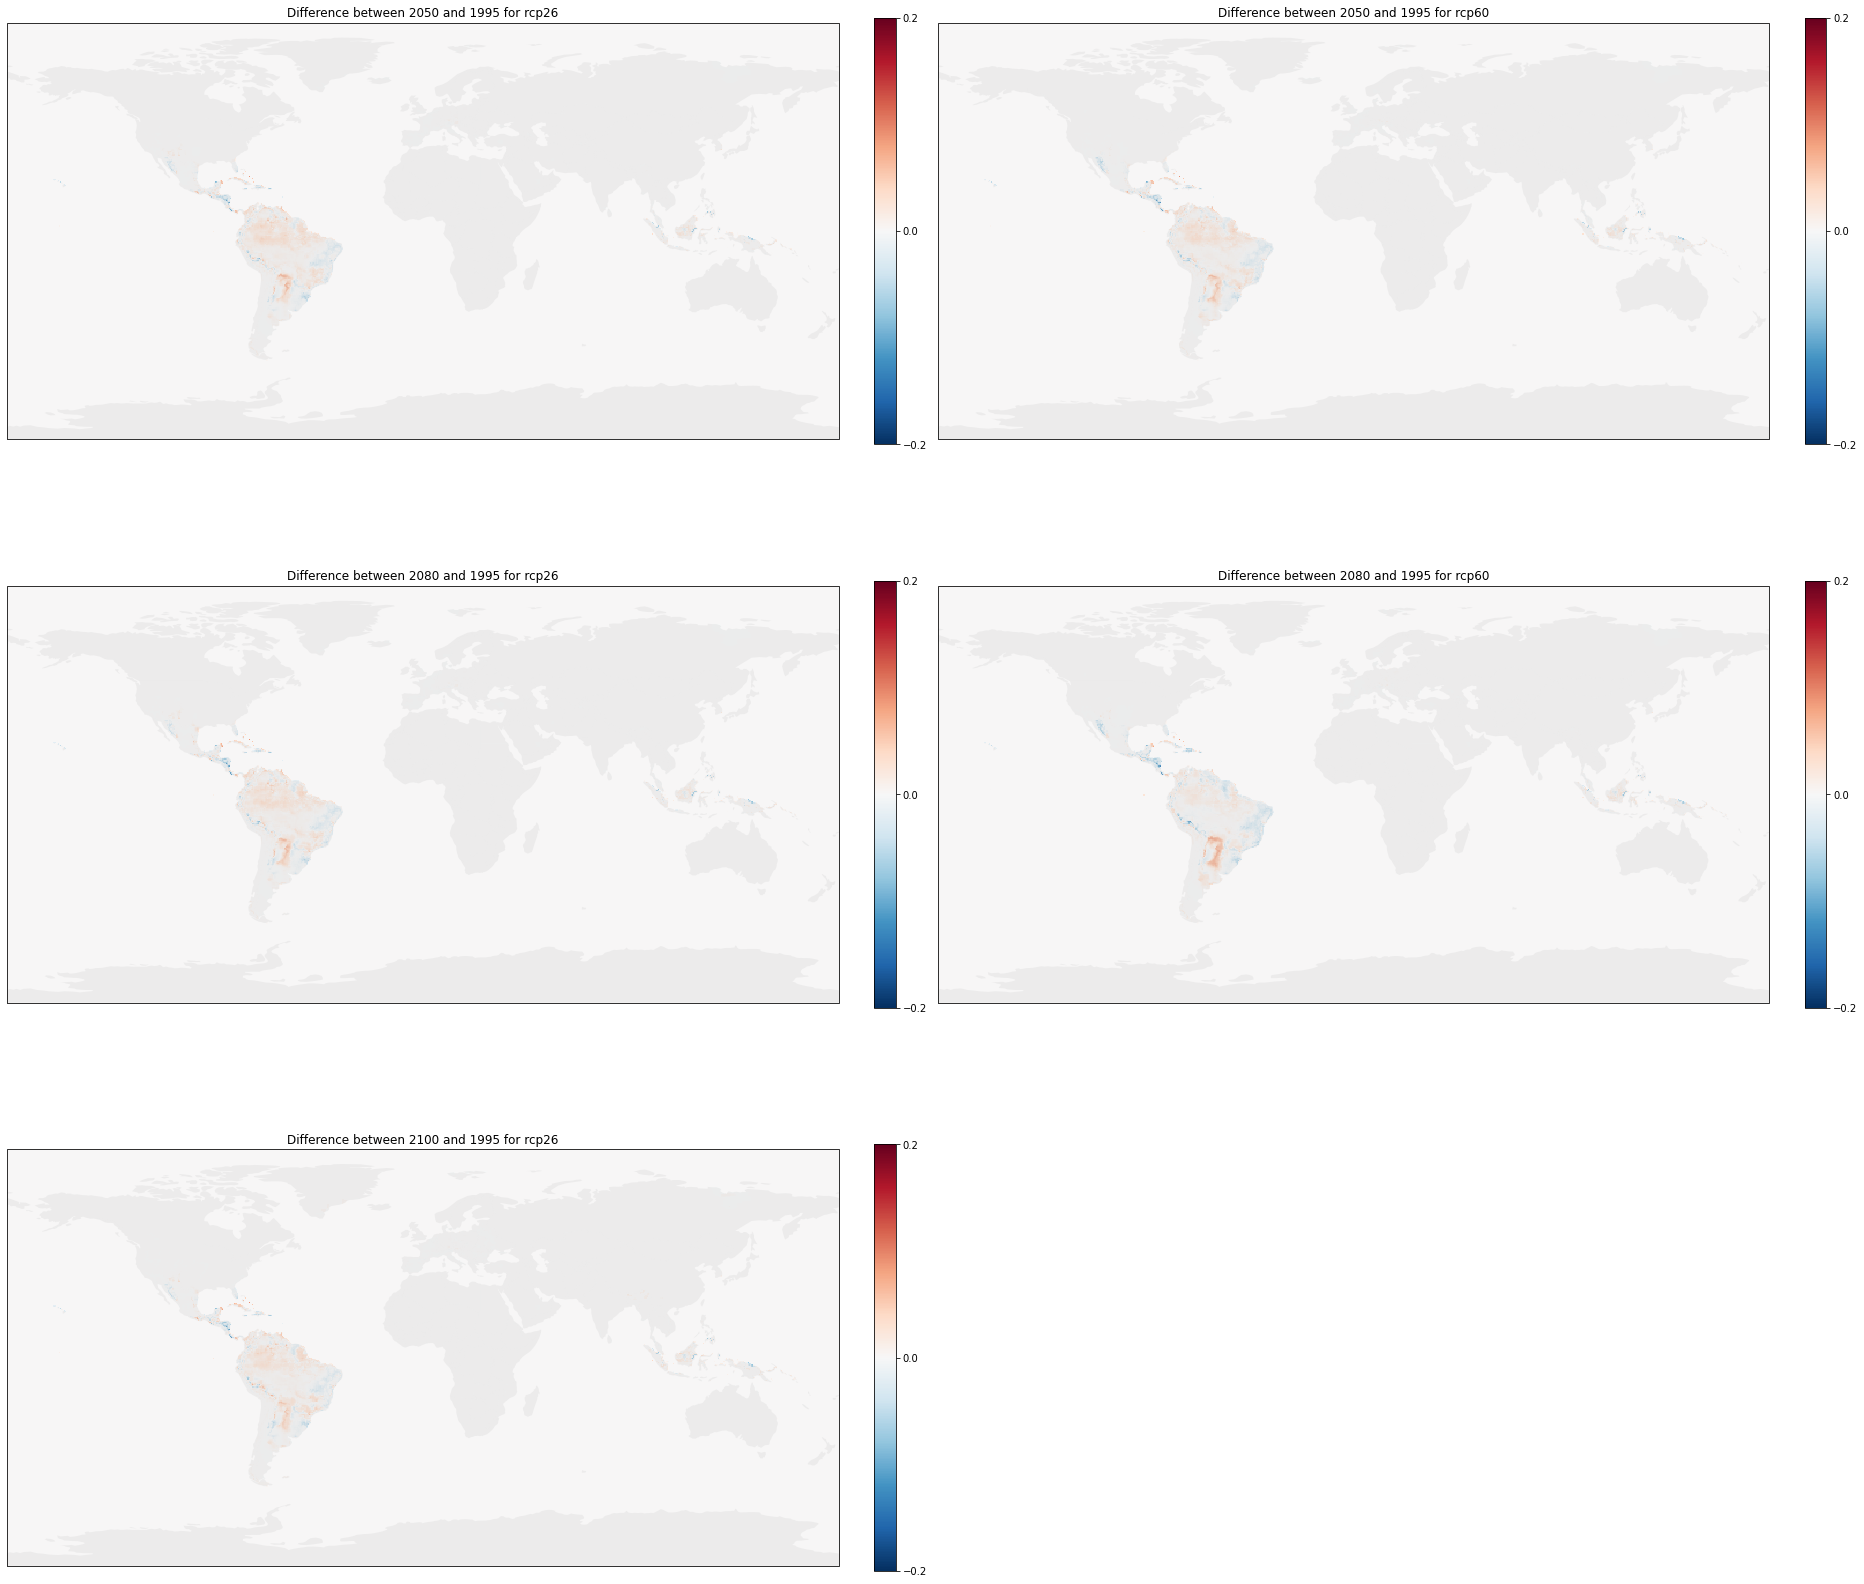

In [5]:
#newvalue
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
            
        mean_future = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
        difference = mean_future - mean_hist
        ax = axes.flatten()[plot_idx]
        im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.2, 0, 0.2])

        plot_idx += 1
axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.show()


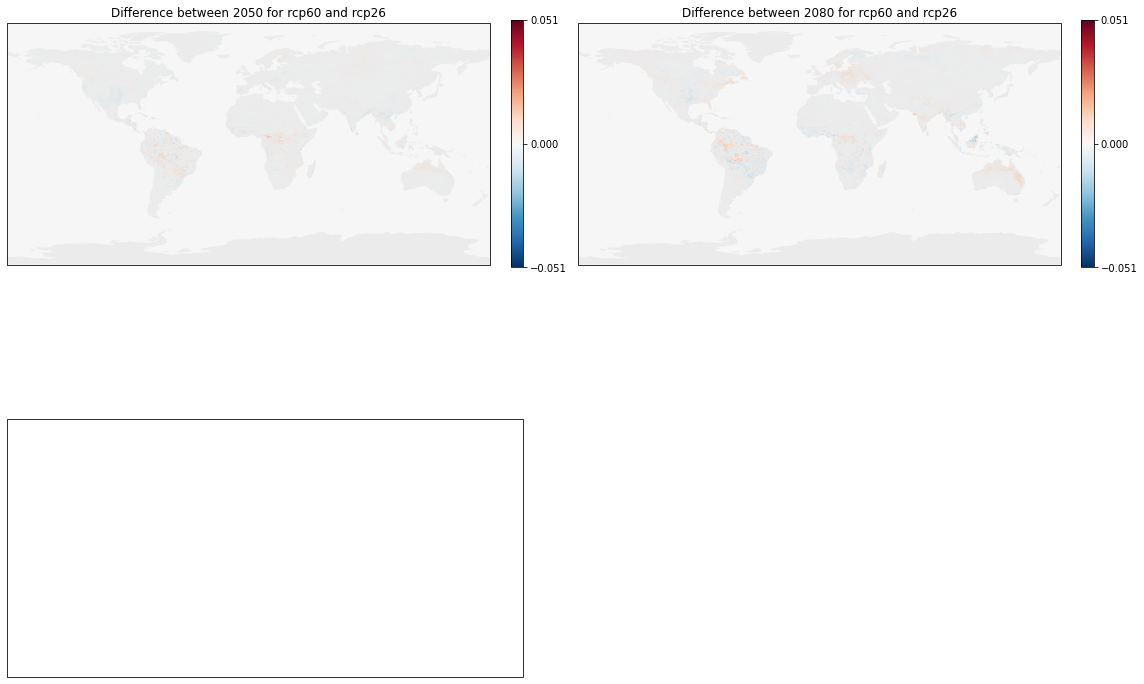

In [47]:
historical_time = 1146
future_times = [35, 65]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {35: '2050', 65: '2080'}

for future_time in future_times:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    for idx, scenario in enumerate(scenarios):
        if idx == 0:
            mean_rcp26 = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
        elif idx == 1:
            mean_rcp60 = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

    difference = mean_rcp60 - mean_rcp26
    ax = axes.flatten()[plot_idx]
    im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.051, vmax=0.051)

    countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
    ax.set_title(f"Difference between {year_indices[future_time]} for rcp60 and rcp26")

    cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
    cbar.set_ticks([-0.051, 0, 0.051])

    plot_idx += 1

axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.show()


In [11]:
#sum_bin _ models individually

def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model_name: {} for model_name in model_names}
    sum_bin_dict = {model_name: {} for model_name in model_names}

    for model_name in model_names:
        for species_name in species_names:
            if is_historical:
                ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
            else:
                ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
            sum_bin = ds["sum_bin"]
            sum_bin_dict[model_name][species_name] = sum_bin

    projections_dict = {}


    for species_name in species_names:
        sum_bin_list = []
        for model_name in model_names:
            sum_bin = sum_bin_dict[model_name][species_name]
            sum_bin_list.append(sum_bin)
        sum_bin_concat = xr.concat(sum_bin_list, dim="model")
        mean_sum_bin = sum_bin_concat.mean(dim="model")
        projections_dict[species_name] = mean_sum_bin

    mean_sum_bin_list = list(projections_dict.values())
    mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

    return mean_sum_bin



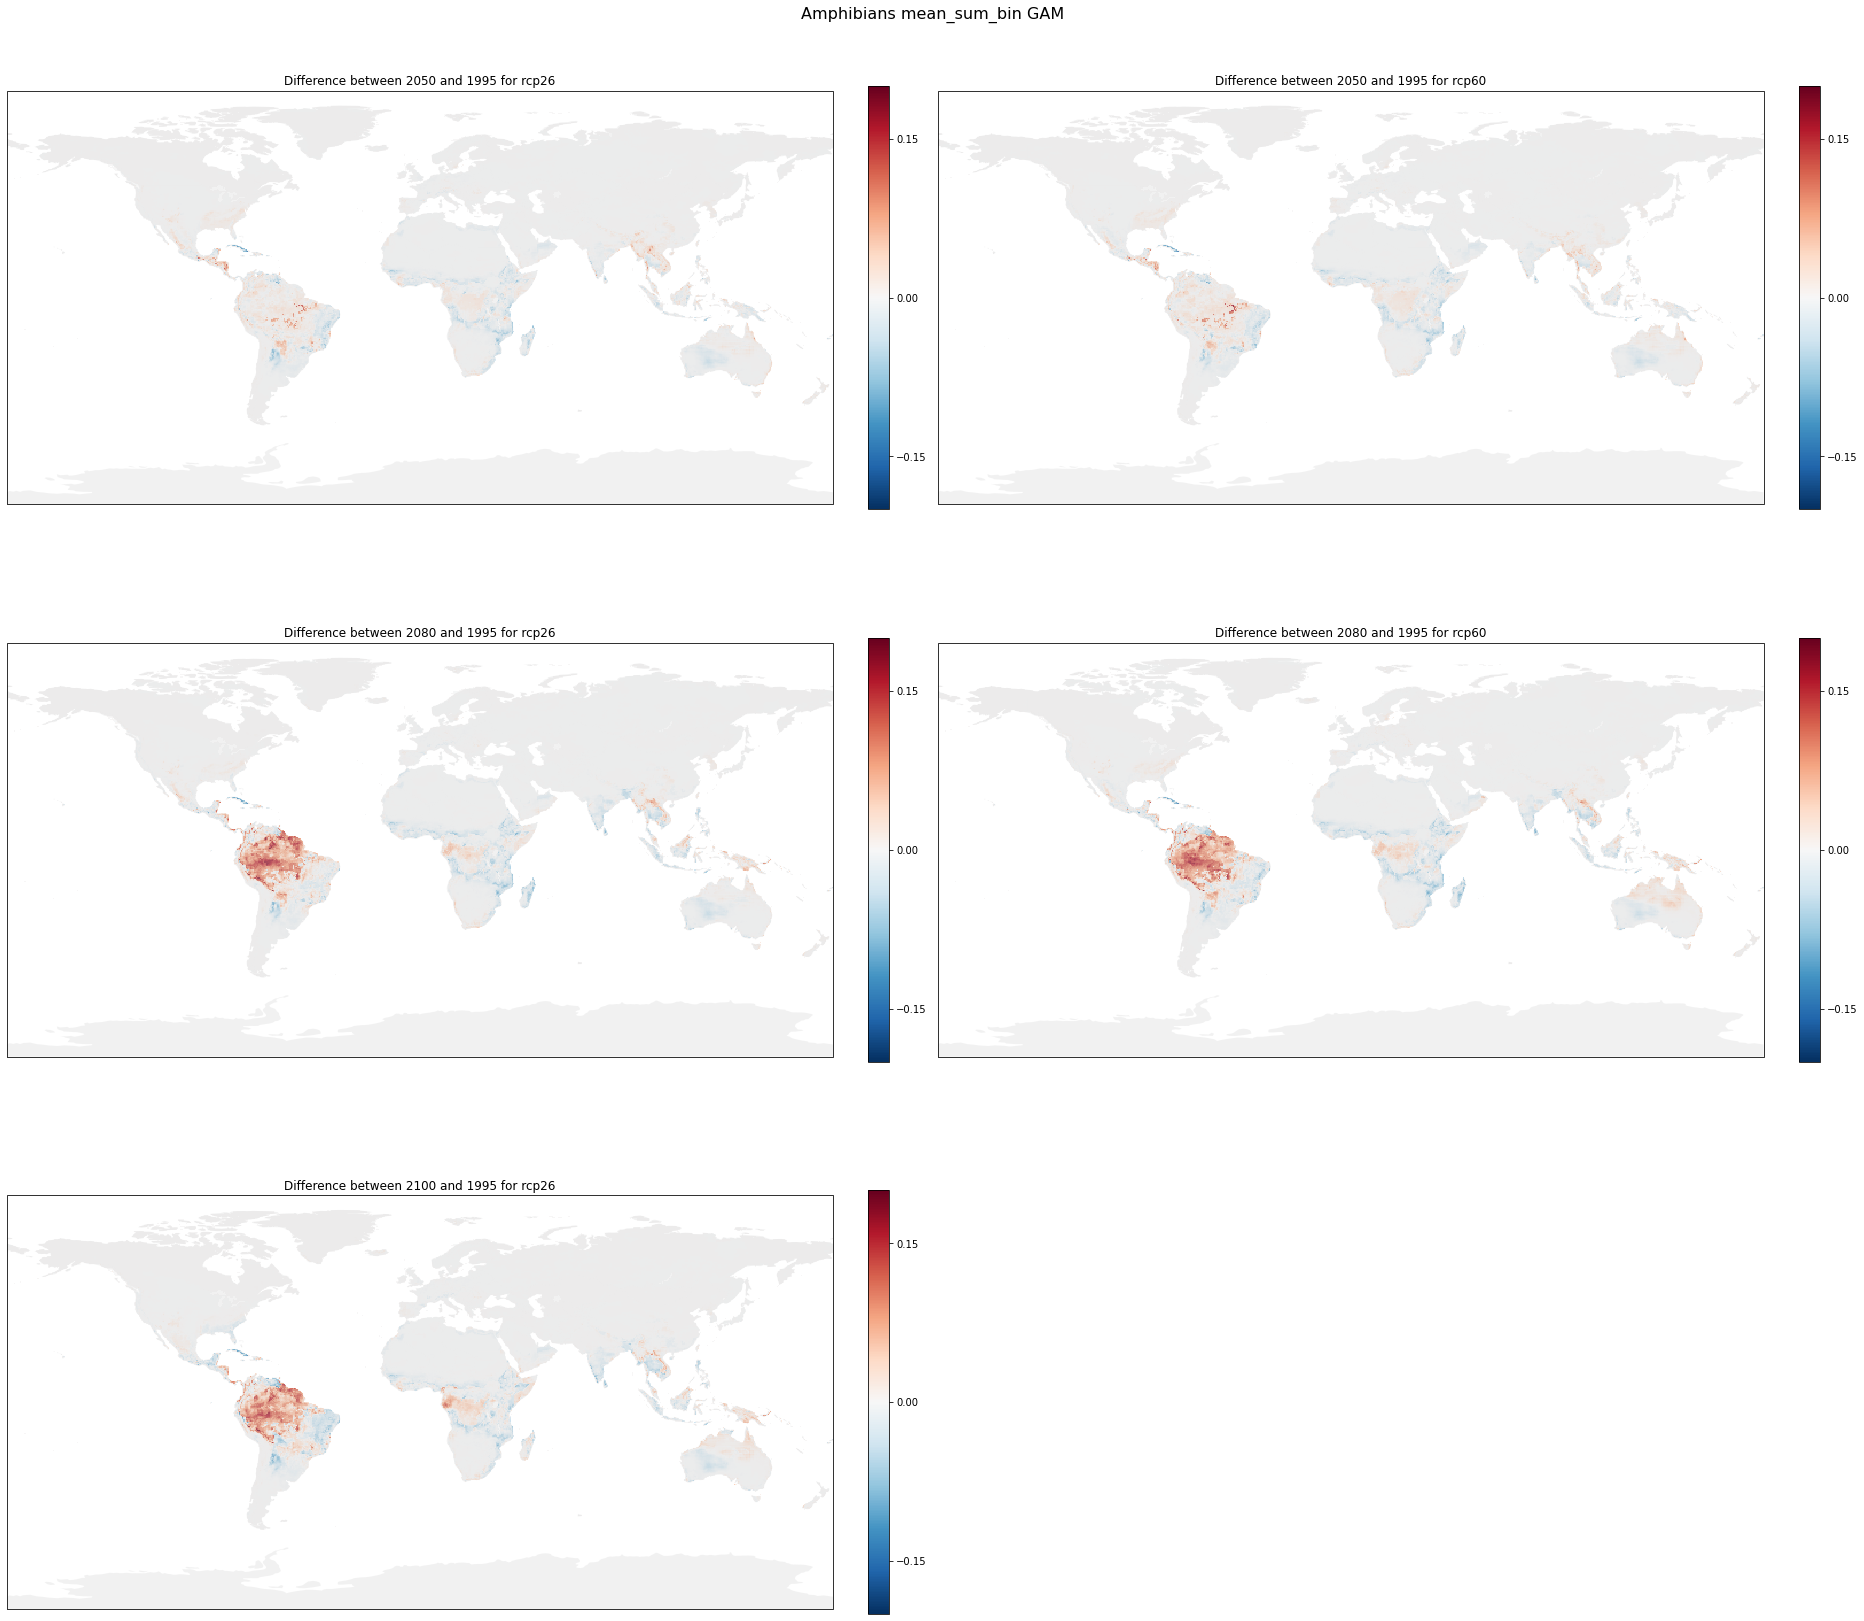

In [12]:
#sum_bin
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]
model="GAM"
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
            

        mean_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

        # Select the 0th time slice in mean_future and mean_hist data arrays
        mean_future_slice = mean_future.isel(time=0)
        mean_hist_slice = mean_hist.isel(time=0)

        difference = mean_future_slice - mean_hist_slice
        ax = axes.flatten()[plot_idx]
        im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.15, 0, 0.15])

        plot_idx += 1

# Hide the last (empty) subplot
axes.flatten()[-1].set_visible(False)
plt.suptitle('Amphibians mean_sum_bin GAM', size=16)

plt.tight_layout()
plt.show()


In [ ]:
models=["GAM", "GBM"]
taxas=["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
                
                
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" +taxa+ "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:1]


        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_bin"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                sum_bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin

    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
    
    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) /2

    # Select the 0th time slice in mean_future and mean_hist data arrays
            mean_future_slice = mean_future.isel(time=0)
            mean_hist_slice = mean_hist.isel(time=0)

            difference = mean_future_slice - mean_hist_slice
            ax = axes.flatten()[plot_idx]
            im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            cbar.set_ticks([-0.15, 0, 0.15])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()


In [ ]:
#count 

taxas=["Mammals"]

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names
        species_names[model] = species_names_model[:1]

for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
xr.DataArray.sum(
            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)
                species_counts_concat = np.mean(species_counts_list, axis=0)  
                projections_dict[species_name] = species_counts_concat

            species_counts_list = list(projections_dict.values())
            species_counts = np.mean(species_counts_list, axis=0) 
ds["sum_bin"] > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}
                        species_counts = 
            return xr.DataArray(species_counts, coords=[ds.lat, ds.lon], dims=['lat', 'lon'])



    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) / 2

            difference = mean_future - mean_hist

            ax = axes.flatten()[plot_idx]
            im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            #cbar.set_ticks([-6, 0, 6])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()
     

ValueError: 'model' not found in array dimensions ('concat_dim', 'lat', 'lon')

In [133]:
difference.plot()

NameError: name 'species_counts' is not defined

In [ ]:
#extinct 
# ...
# Step 1: Modify the calculate_model_mean function


taxas=["Mammals"]

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names
        species_names[model] = species_names_model[:100]

for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        species_counts = xr.DataArray.sum(ds["sum_bin"] > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}

            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)
                species_counts_concat = np.mean(species_counts_list, axis=0)  
                projections_dict[species_name] = species_counts_concat

            species_counts_list = list(projections_dict.values())
            species_counts = np.mean(species_counts_list, axis=0) 

            return xr.DataArray(species_counts, coords=[ds.lat, ds.lon], dims=['lat', 'lon'])

        def count_extinct_species(past_data, future_data):
            return xr.DataArray.sum((past_data > 0) & (future_data == 0), axis=0)

    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) / 2

            difference = mean_future - mean_hist

            mean_past_gam, mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_past_gbm, mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)

            extinct_species_gam = count_extinct_species(mean_past_gam, mean_future_gam)
            extinct_species_gbm = count_extinct_species(mean_past_gbm, mean_future_gbm)
            extinct_species = (extinct_species_gam + extinct_species_gbm) / 2

            # Replace 'difference' with 'extinct_species' in the plotting code
            ax = axes.flatten()[plot_idx]
            im = extinct_species.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=0)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            cbar.set_ticks([-6, 0, 6])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()
     



In [78]:
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)

In [79]:
mean_hist_gam

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [74]:
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        mean_future = (mean_future_gam + mean_future_gbm) /2

        # Select the 0th time slice in mean_future and mean_hist data arrays
        mean_future_slice = mean_future
        mean_hist_slice = mean_hist

        difference = mean_future_slice - mean_hist_slice

        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

        # create pcolormesh plot
        difference.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.2, vmax=0.2)

        # create contourf plot on top of pcolormesh
        difference.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=10, alpha=0.5, cmap='RdBu_r', vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.15, 0, 0.15])

        plt.show()


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [61]:
mean_future_gam

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names
        species_names[model] = species_names_model[:10]

        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        prob = ds["sum_bin"].values
                        species_counts = xr.DataArray.sum(prob > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}

            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)

In [9]:
species_counts_list

NameError: name 'species_counts_list' is not defined

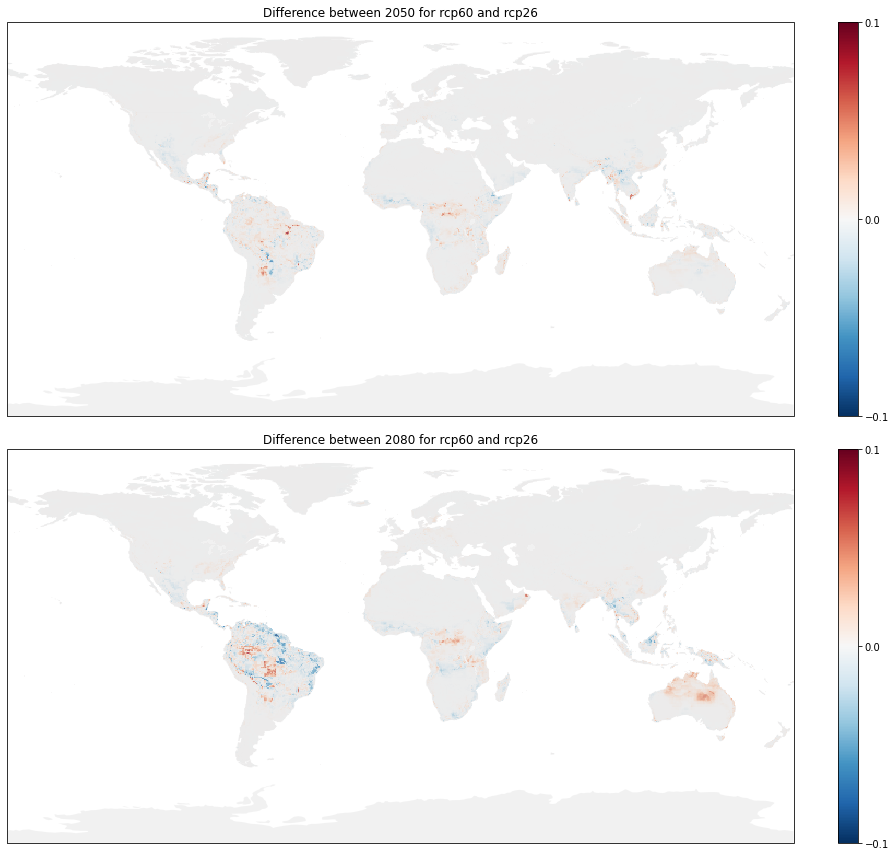

In [13]:
historical_time = 1146
future_times = [35, 65]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {35: '2050', 65: '2080'}

for future_time in future_times:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    for idx, scenario in enumerate(scenarios):
        if idx == 0:
            mean_rcp26 = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
        elif idx == 1:
            mean_rcp60 = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
    mean_rcp60 = mean_rcp60.isel(time=0)
    mean_rcp26 = mean_rcp26.isel(time=0)
    difference = mean_rcp60 - mean_rcp26
    ax = axes.flatten()[plot_idx]
    im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.1, vmax=0.1)

    countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
    ax.set_title(f"Difference between {year_indices[future_time]} for rcp60 and rcp26")

    cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
    cbar.set_ticks([-0.1, 0, 0.1])

    plot_idx += 1

#axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.show()


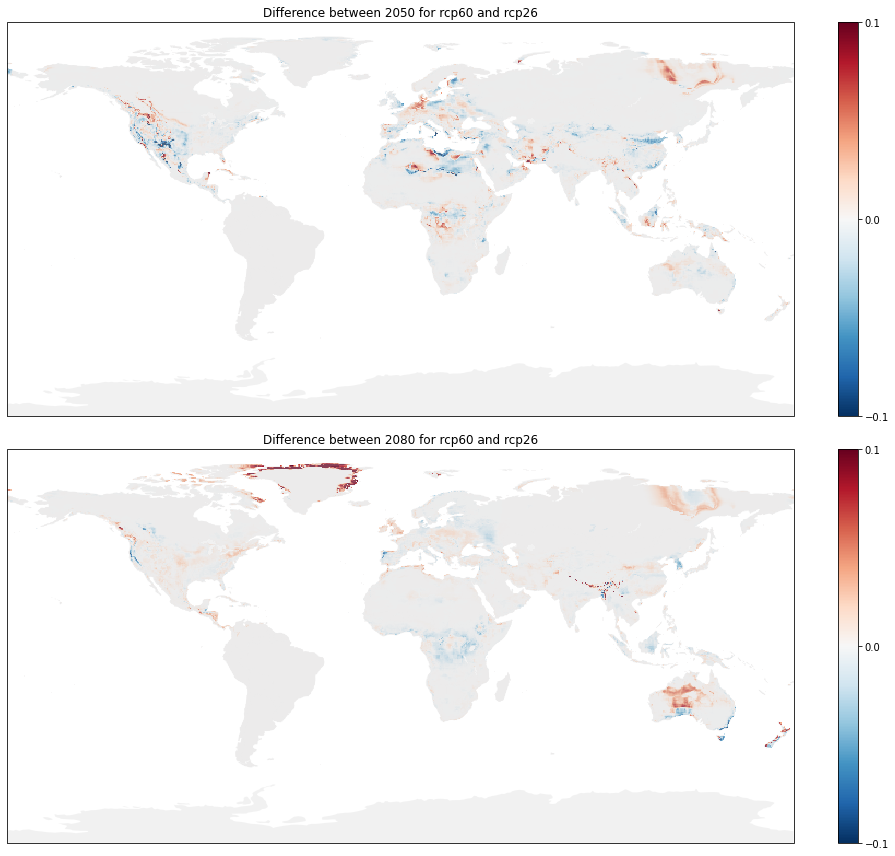

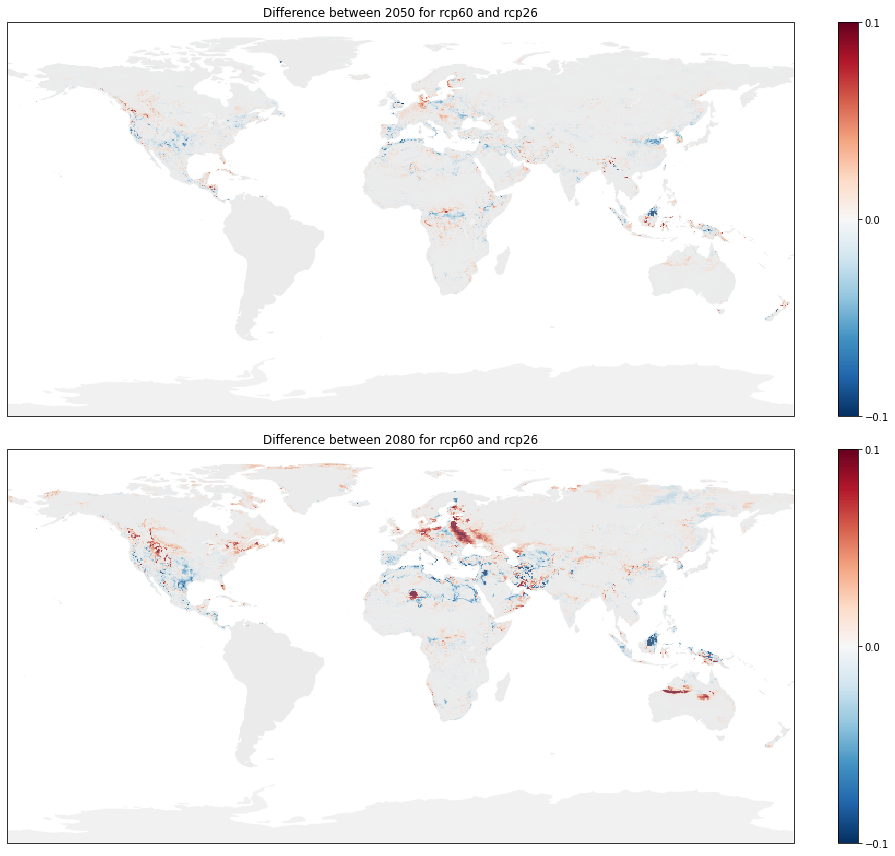

In [3]:
models=["GAM","GBM"]
taxas=["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
                
                
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" +taxa+ "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:10]

        #sum_bin 

        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model,taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}


            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin

        historical_time = 1146
        future_times = [35, 65]
        scenarios = ["rcp26", "rcp60"]

        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {35: '2050', 65: '2080'}

        for future_time in future_times:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            for idx, scenario in enumerate(scenarios):
                if idx == 0:
                    mean_rcp26 = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                elif idx == 1:
                    mean_rcp60 = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_rcp60 = mean_rcp60.isel(time=0)
            mean_rcp26 = mean_rcp26.isel(time=0)
            difference = mean_rcp60 - mean_rcp26
            ax = axes.flatten()[plot_idx]
            im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.1, vmax=0.1)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} for rcp60 and rcp26")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            cbar.set_ticks([-0.1, 0, 0.1])

            plot_idx += 1

        #axes.flatten()[-1].set_visible(False)

        plt.tight_layout()
       

In [ ]:

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
                
                
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" +taxa+ "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:10]

        #sum_bin 

KeyError: 'GAM GAM'

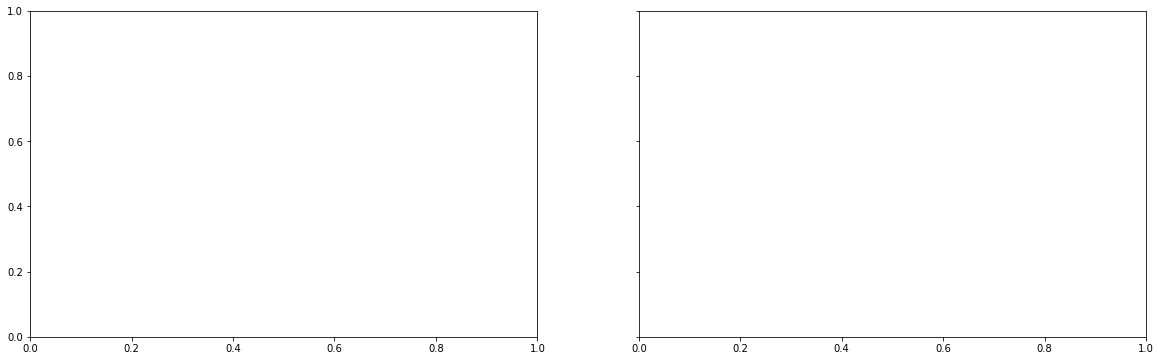

In [15]:
def calculate_uncertainty_future(time, models, model_names, netcdf_path_format, scenario):
    uncertainties = {model: {} for model in models}

    for model in models:
        for model_name in model_names:
            sum_bin_list = []
            for species_name in species_names:
                ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                sum_bin = ds["sum_bin"]
                #print(f"sum_bin for {model} {model_name} {species_name}: {sum_bin.mean().item()}")
                sum_bin_list.append(sum_bin)
            sum_bin_concat = xr.concat(sum_bin_list, dim="species")
            std_sum_bin = sum_bin_concat.std(dim="species")
            #print(f"std_sum_bin for {model} {model_name}: {std_sum_bin.mean(dim=['lat', 'lon']).item()}")
            uncertainties[model][model_name] = std_sum_bin.mean(dim=["lat", "lon"]).item()

    return uncertainties


# Calculate uncertainties for future projections
uncertainties_future = {}
for scenario in scenarios:
    uncertainties_future[scenario] = {}
    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]
        uncertainties_future[scenario][future_time] = calculate_uncertainty_future(future_time, models, model_names, netcdf_path_format_future, scenario)

all_model_names = ['GAM ' + m for m in models] + ['GBM ' + m for m in models]

# Create the stacked bar plot
fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(10 * len(scenarios), 6), sharey=True)
axes = np.atleast_1d(axes)

model_name_indices = np.arange(len(all_model_names))
for i, scenario in enumerate(scenarios):
    ax = axes[i]
    for future_time in future_times:
        present_models = set([m.split(' ')[1] for m in uncertainties_future[scenario][future_time].keys() if ' ' in m])

        model_names = [m for m in all_model_names if m.split(' ')[1] in present_models]
        bottoms = np.zeros(len(model_names))
        for j, model in enumerate(model_names):
            if model.split(' ')[1] in present_models:
                model_std = [uncertainties_future[scenario][future_time][f"{prefix}{model.split(' ')[1]}"][species_name] for prefix in ['GAM ', 'GBM'] for species_name in species_names]
                ax.bar(model_name_indices, model_std, bottom=bottoms, label=model + ' ' + str(future_time))

                bottoms += model_std

    ax.set_xticks(model_name_indices)
    ax.set_xticklabels(all_model_names)
    ax.set_title(scenario)
    ax.set_xlabel('Model names')
    ax.set_ylabel('Uncertainty')

axes[0].legend()
plt.tight_layout()
plt.show()


In [39]:
def calculate_uncertainty_future(time, models, model_names, netcdf_path_format, scenario):
    uncertainties = {model: {} for model in models}

    for model in models:
        for model_name in model_names:
            sum_bin_list = []
            for species_name in species_names:
                ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                sum_bin = ds["sum_bin"]
                sum_bin_list.append(sum_bin)
            sum_bin_concat = xr.concat(sum_bin_list, dim="species")
            std_sum_bin = sum_bin_concat.std(dim="species")
            uncertainties[model][model_name] = std_sum_bin.mean(dim=["lat", "lon"]).item()

    return uncertainties


# Calculate uncertainties for future projections
uncertainties_future = {}
for scenario in scenarios:
    uncertainties_future[scenario] = {}
    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        
        uncertainties_future[scenario][future_time] = calculate_uncertainty_future(future_time, models, model_names, netcdf_path_format_future, scenario)

fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(10 * len(scenarios), 6), sharey=True)
axes = np.atleast_1d(axes)

model_name_indices = np.arange(len(all_model_names))

colors = ["dodgerblue", "orange", "limegreen"]
time_legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=f"Time {t}") for color, t in zip(colors, future_times)]

for i, scenario in enumerate(scenarios):
    ax = axes[i]
    for j, future_time in enumerate(future_times):
        bottoms = np.zeros(len(all_model_names))
        for k, model in enumerate(all_model_names):
            model_std = [uncertainties_future[scenario][future_time][f"{prefix}{model.split(' ')[1]}"][species_name] for species_name in species_names for prefix in ['GAM ', 'GBM'] if f"{prefix}{model.split(' ')[1]}" in uncertainties_future[scenario][future_time]]
            ax.bar(model_name_indices[k], model_std, bottom=bottoms, color=colors[j], width=0.4)

            bottoms += model_std

    ax.set_xticks(model_name_indices)
    ax.set_xticklabels(all_model_names)
    ax.set_title(scenario)
    ax.set_xlabel('Model names')
    ax.set_ylabel('Uncertainty')

axes[0].legend(handles=time_legend_elements, title="Time periods")
plt.tight_layout()
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: b'/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Mammals/IPSL-CM5A-LR/rcp60/Harpiola_isodon_[85].nc'

In [68]:
time=[65]
#get the species_names in xx_xx format
for model in models :
    for model_name in model_names:
                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/new/" 

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/Mammals_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = "_".join(split_species_name)
                            formatted_names.append(formatted_species_name)
species_names=formatted_names[:5]    

dir_path="/storage/scratch/users/ch21o450/data/LandClim_Output/"
# create empty dictionaries to store the data arrays for each model
newvalue_dict = {model_name: {} for model_name in model_names}
sum_bin_dict = {model_name: {} for model_name in model_names}

# loop over the model names
for model_name in model_names:
    # loop over the species names
    for species_name in species_names:
        # read in the netCDF file
        ds = xr.open_dataset(
            dir_path + model + "/" + taxas[0]  +"/" + model_name + "/" + scenarios[0] + "/"
            + species_name + "_" +  str(time) +".nc" , decode_times=False
        )
        # extract the newvalue and sum_bin data arrays for the 35th time step
        newvalue = ds["newvalue"]
        sum_bin = ds["sum_bin"]
        
        # add the data arrays to the dictionaries for the current model and species
        newvalue_dict[model_name][species_name] = newvalue
        sum_bin_dict[model_name][species_name] = sum_bin

# create an empty dictionary to store the projections for each species
projections_dict = {}

# loop over the species names
for species_name in species_names:
    # create an empty list to store the sum_bin data arrays for the current species
    sum_bin_list = []
    # loop over the model names and append the sum_bin data array to the list
    for model_name in model_names:
        sum_bin = sum_bin_dict[model_name][species_name]
        sum_bin_list.append(sum_bin)
    # concatenate the sum_bin data arrays along a new dimension called "model"
    sum_bin_concat = xr.concat(sum_bin_list, dim="model")
    # take the mean of the sum_bin data array along the "model" dimension
    mean_sum_bin = sum_bin_concat.mean(dim="model")
    # add the mean sum_bin data array to the projections dictionary for the current species
    projections_dict[species_name] = mean_sum_bin


In [69]:
time=[1146]

dir_path="/storage/scratch/users/ch21o450/data/LandClim_Output/"
# create empty dictionaries to store the data arrays for each model
newvalue_dict_hist = {model_name: {} for model_name in model_names}
sum_bin_dict_hist = {model_name: {} for model_name in model_names}

# loop over the model names
for model_name in model_names:
    # loop over the species names
    for species_name in species_names:
        # read in the netCDF file
        ds = xr.open_dataset(
            dir_path + model + "/" + taxas[0]  +"/EWEMBI/"
            + species_name + "_" +  str(time) +".nc" , decode_times=False
        )
        # extract the newvalue and sum_bin data arrays for the 35th time step
        newvalue = ds["newvalue"]
     
        
        # add the data arrays to the dictionaries for the current model and species
        newvalue_dict[model_name][species_name] = newvalue
     
        # create an empty dictionary to store the projections for each species
projections_dict = {}

# loop over the species names
for species_name in species_names:
    # create an empty list to store the sum_bin data arrays for the current species
    value_list = []
    # loop over the model names and append the sum_bin data array to the list
    for model_name in model_names:
        value_bin = newvalue_dict[model_name][species_name]
        value_list.append(value_bin)
    # concatenate the sum_bin data arrays along a new dimension called "model"
    value_bin_concat = xr.concat(value_list, dim="model")
    # take the mean of the sum_bin data array along the "model" dimension
    mean_value_bin = value_bin_concat.mean(dim="model")
    # add the mean sum_bin data array to the projections dictionary for the current species
    projections_dict[species_name] = mean_value_bin
value_bin_list = list(projections_dict.values())
mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")


In [70]:
past_future=mean_sum_bin -mean_value_bin 

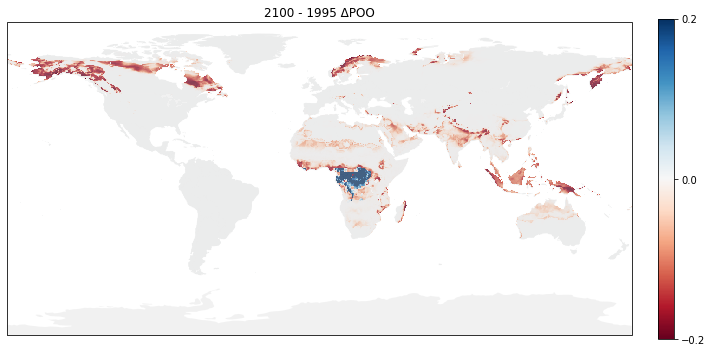

In [ ]:
#martes orig POO
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data on the first subplot
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
im1 = past_future.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="RdBu", add_colorbar=False, vmin=-0.2, vmax=0.2)

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)
cbar1.set_ticks([-0.2,0,0.2])
countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)

ax1.set_title("2100 - 1995 \u0394POO")

plt.tight_layout()
#fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/martes_melampus_proj_range_6.0.png")

lats = np.arange(-180,180,0.5)
lons = np.arange(-360,360,0.5)
